# Classifying Tweets about Roe vs. Wade

In June 2022, Roe v. Wade was overturned by the Supreme Court. Since then, there have been countless laws passed restricting abortion access, and even lawsuits introduced working to restrict access in states where the procedure remains legal (namely through trying to ban the abortion drug Mifepristone). These news have galvanized members of the American public on both sides: either through mourning the loss of access or celebrating a victory for the pro-life movement. And, a lot of these people have taken to Twitter to share their thoughts, opinions, and feelings about the ruling.



In this project, my goal was to see if it was possible to identify whether tweets were pro-life or pro-choice based on the language used. I did this by using a dataset of preclassified tweets about the decision, which included data about the content of the tweets, users, and their bios. I ran this data through a classification model that worked to predict whether the tweet was classified as pro-life or pro-choice based on the training data provided. 

This classifier needs Keras to be installed in order to run.

#### Imports & Utils

In [1]:
import tensorflow
from tensorflow import keras
import pandas as pd
import numpy as np

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import os

In [3]:
!pip install scikit-learn

#### Resources Used

Dataset: https://app.surgehq.ai/datasets/roe-v-wade-tweets

Helpful tutorial that helped lay out a simple version of the classifier: https://www.kaggle.com/code/sanikamal/text-classification-with-python-and-keras

IMDB Movie review classifier: chapter04_getting-started-with-neural-networks.ipynb and looked at chapter11_part03_transformer.ipynb from https://github.com/fchollet/deep-learning-with-python-notebooks 

## Reading in the data from the CSV

In [4]:
data = pd.read_csv(
    "abortion_tweets_dataset.csv",
    names=["worker_id", "task_id", "task_response_id", "tweet_id", "text",
           "username", "bio", "category_label"])

# Reduced the labels to numbers for simplicity
# Pro-life = 0, pro-choice = 1
data['category'] = np.where(data['category_label'] == 'Pro-life', 0, 1)

data = data.drop(index=0)

df_tweet = data[['text', 'category']]

In [5]:
df_tweet.head()

,text,category
1,"Delete Facebook, hit the streets https://t.co...",1
2,@Razzaque_Ayesha This was indeed one of the fe...,0
3,"With Roe v. Wade overturned, the #Canadian pub...",1
4,@ewarren https://t.co/S2VAwXI9n8,1
5,More telling: How the Justices see themselves ...,1


### Dividing the dataset into training and testing

In [6]:
tweets = df_tweet['text'].values
y = df_tweet['category'].values

tweets_train, tweets_test, y_train, y_test = train_test_split(tweets, y, test_size=0.25, random_state=1000)

### Preprocessing

Used a vectorizer to remove punctuation and special characters and apply other preprocessing to each word.

In [7]:
vectorizer = CountVectorizer()
vectorizer.fit(tweets_train)

X_train = vectorizer.transform(tweets_train)
X_test  = vectorizer.transform(tweets_test)

## Classification

I ran several different iterations of classification models on the dataset to see which ones worked the best.

### Baseline

Accuracy: 0.6926070038910506

In [8]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.6926070038910506


### Using Keras

In [9]:
input_dim = X_train.shape[1]

def build_model():
    return keras.Sequential([
        layers.Dense(10, input_dim=input_dim, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

model = build_model()

2023-04-27 15:22:58.397120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def compile_model(model):
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    #model.summary()
    
compile_model(model)

I played around a bit with the number of epochs, and after looking at the performance graphs found that it was between 10-20 was when the performance dropped off the most. From this, I decided to use epoch=15. I played around with the batch size but did not notice a significant difference unless it was over 100, so left it at 32.

Below is the graphs for the performance of the model at 100 epochs and a batch size of 32.

<div>
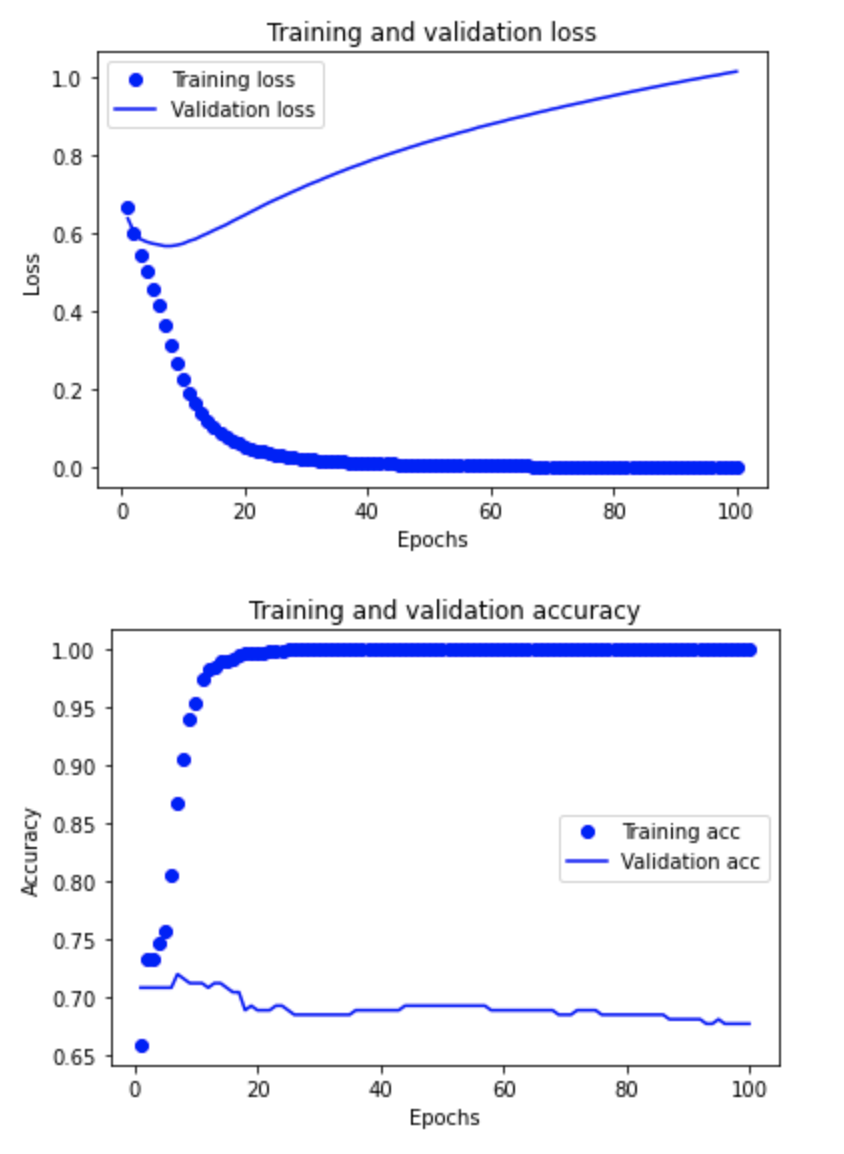
</div>

In [11]:
def run_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, verbose):
    return model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=verbose,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)
    
history = run_model(model, X_train, y_train, X_test, y_test, 10, 32, True)

Epoch 1/10


/Users/chloestrandwold/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


24/24 [==============================] - 1s 11ms/step - loss: 0.6432 - accuracy: 0.7031 - val_loss: 0.6098 - val_accuracy: 0.7082
Epoch 2/10
24/24 [==============================] - 0s 2ms/step - loss: 0.5449 - accuracy: 0.7331 - val_loss: 0.5898 - val_accuracy: 0.7082
Epoch 3/10
24/24 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.7370 - val_loss: 0.5851 - val_accuracy: 0.7082
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.4400 - accuracy: 0.7695 - val_loss: 0.5826 - val_accuracy: 0.7043
Epoch 5/10
24/24 [==============================] - 0s 2ms/step - loss: 0.3881 - accuracy: 0.8203 - val_loss: 0.5798 - val_accuracy: 0.7160
Epoch 6/10
24/24 [==============================] - 0s 2ms/step - loss: 0.3359 - accuracy: 0.8893 - val_loss: 0.5785 - val_accuracy: 0.7198
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2840 - accuracy: 0.9297 - val_loss: 0.5805 - val_accuracy: 0.7160
Epoch 8/10
24/24 [============

#### Evaluating the Model

In [12]:
def print_eval():
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    
    
print_eval()

Training Accuracy: 0.9870
Testing Accuracy:  0.7121


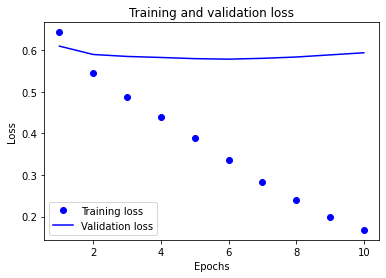

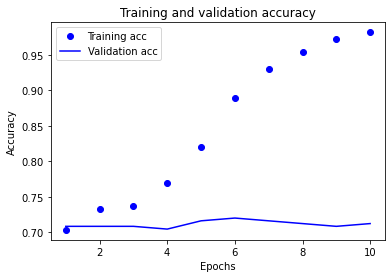

In [13]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.clf()
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
plot_history(history)

### Iterating on Keras

I added several layers to the model, using word embeddings.

Testing Accuracy: 0.7082

In [14]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(tweets_train)

X_train = tokenizer.texts_to_sequences(tweets_train)
X_test = tokenizer.texts_to_sequences(tweets_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [15]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 339  340   14   20    4  412    5  108   30  684  413    5  108    7
   11    9  161    6 1158  172   42    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [16]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           215300    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 215,821
Trainable params: 215,821
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100)

In [18]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7891
Testing Accuracy:  0.7121


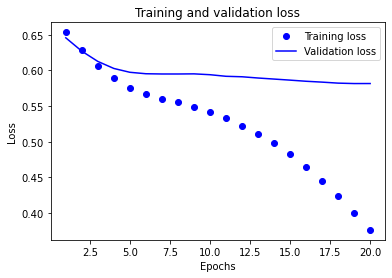

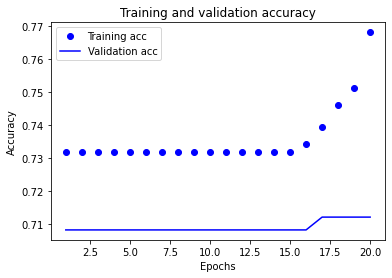

In [19]:
plot_history(history)

In addition to all of these, I experimented with changing the `mse` loss function instead of `binary_crossentropy` and trying the `tanh` activation instead of `relu` but did not find that these worked better with the data set.

### Convolutional Neural Network (CNN)

I also experimented with using a Convolutional Neural Network with hidden layers to see if it could detect any hidden patterns in the data. 

Testing accuracy: 0.73.15

In [20]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           215300    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 248,729
Trainable params: 248,729
Non-trainable params: 0
________________________________________________

Training Accuracy: 0.9987
Testing Accuracy:  0.7160


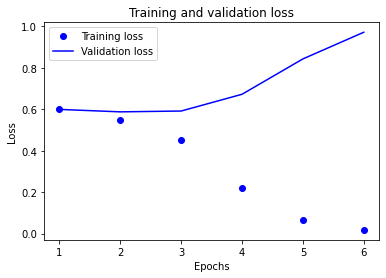

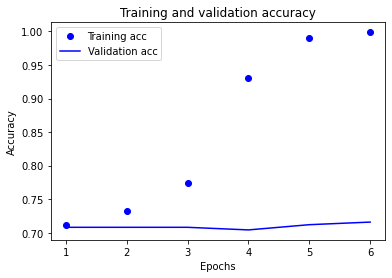

In [21]:
history = model.fit(X_train, y_train,
                    epochs=6,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Optimization Using Grid Search

In [22]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [23]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

sentences = df_tweet['text'].values
y = df_tweet['category'].values

# Train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
    
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                    kernel_size=[3, 5, 7],
                    vocab_size=[vocab_size],
                    embedding_dim=[embedding_dim],
                    maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                            cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
test_accuracy = grid.score(X_test, y_test)
    
s = ('Running data set\nBest Accuracy : '
            '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
    grid_result.best_score_,
    grid_result.best_params_,
    test_accuracy)
print(output_string)

/var/folders/zl/xtrm36z51tn5phh9qmvt4mfc0000gn/T/ipykernel_5820/2098737610.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


Fitting 4 folds for each of 5 candidates, totalling 20 fits
Running data set
Best Accuracy : 0.7031
{'vocab_size': 4306, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 7, 'embedding_dim': 50}
Test Accuracy : 0.5214




## Using the Model on Bios

I was looking over the dataset site, and noticed that they had some interesting takeaways about the bios of the posters. It made me curious if the bios may be a better predictor than the actual content of the tweet itself, as twitter bios often contain a lot of political and personal information that may be more specific than the tweet text itself.

Here are the takeaways from the dataset site:

<div>
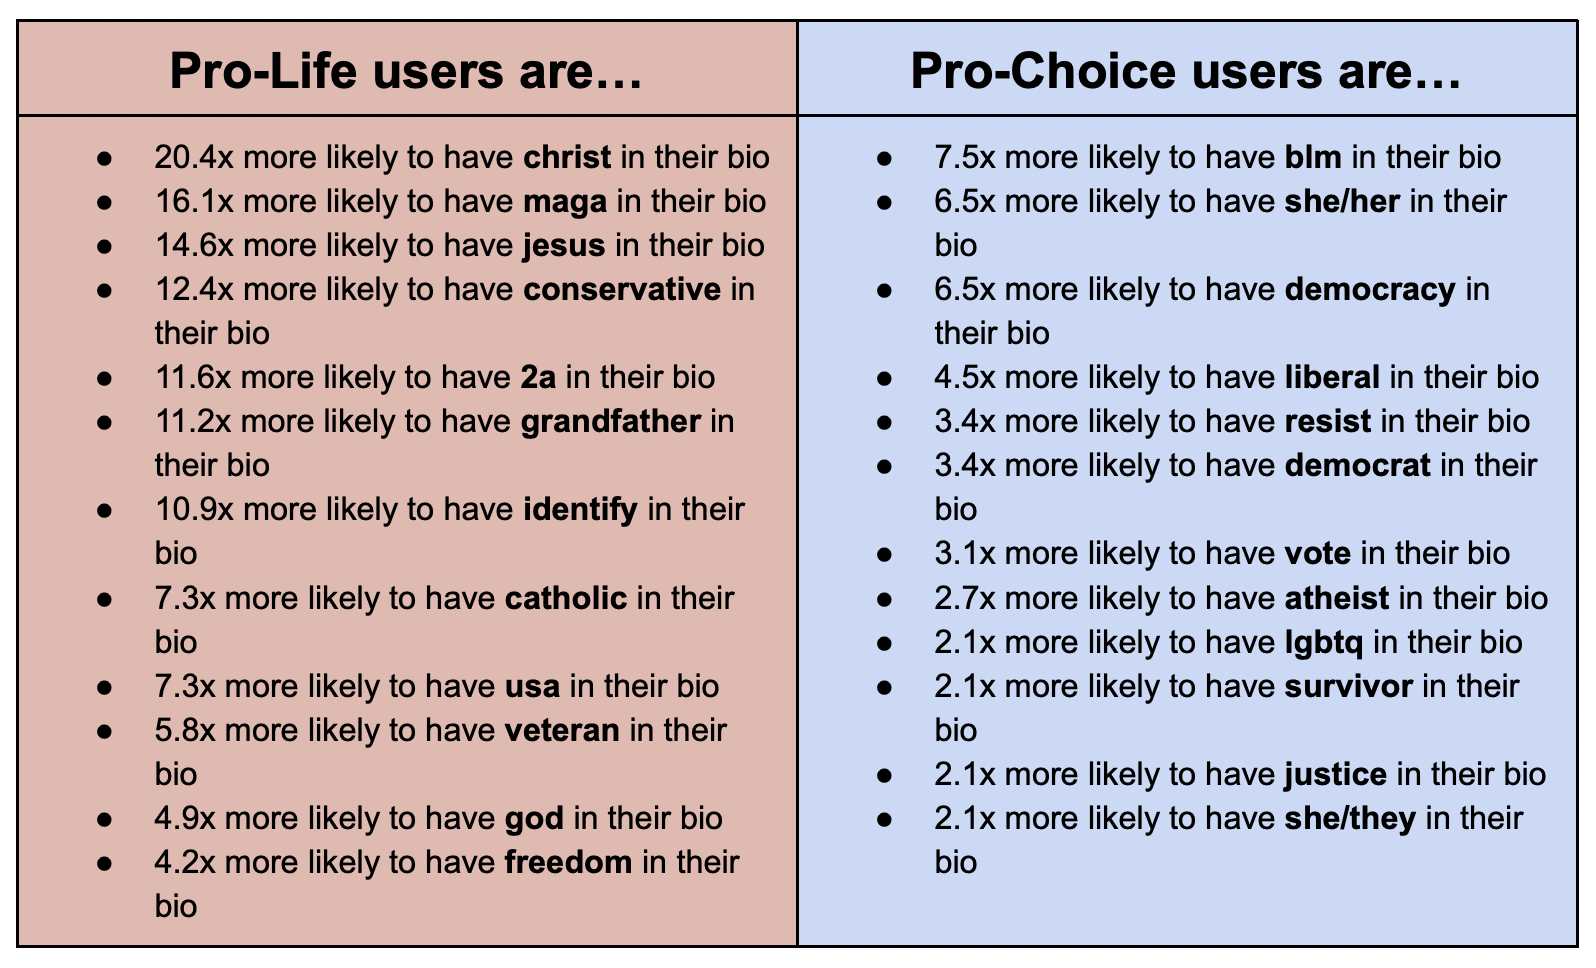
</div>

#### Preproccessing

In [24]:
df_bios = data[['bio', 'category']]

bios = df_bios['bio'].values.astype('U')
y = df_bios['category'].values

bios_train, bios_test, y_train, y_test = train_test_split(bios, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
vectorizer.fit(bios_train)

x_train = vectorizer.transform(bios_train)
x_test  = vectorizer.transform(bios_test)

#### Base Classifier

Accuracy: 0.7392996108949417

In [25]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print("Accuracy:", score)

Accuracy: 0.7392996108949417


#### Keras

Training Accuracy: 0.9310

Testing Accuracy:  0.7471

In [31]:
input_dim = x_train.shape[1]

model = keras.Sequential([
    layers.Dense(10, input_dim=input_dim, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=40,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=32)

/Users/chloestrandwold/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_27/dense_54/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_27/dense_54/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_27/dense_54/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Training Accuracy: 0.9310
Testing Accuracy:  0.7471


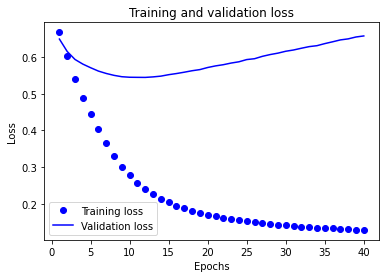

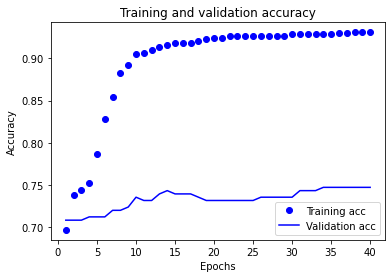

In [32]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

#### Iterating

Training Accuracy: 0.7409

Testing Accuracy:  0.7121

In [33]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(tweets_train)

X_train = tokenizer.texts_to_sequences(tweets_train)
X_test = tokenizer.texts_to_sequences(tweets_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 100, 50)           215300    
                                                                 
 global_max_pooling1d_25 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_56 (Dense)            (None, 10)                510       
                                                                 
 dense_57 (Dense)            (None, 1)                 11        
                                                                 
Total params: 215,821
Trainable params: 215,821
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.7409
Testing Accuracy:  0.7121


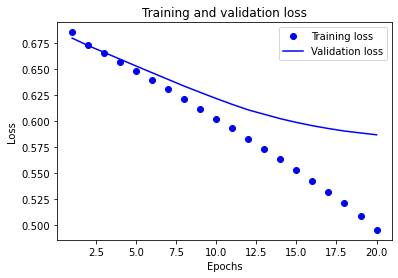

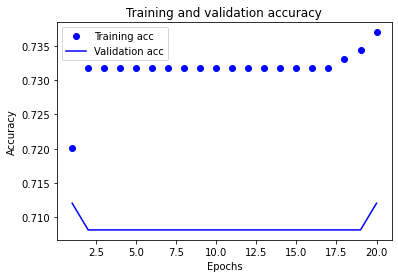

In [34]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

#### CNN

Training Accuracy: 0.9987

Testing Accuracy:  0.7432

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 100, 50)           215300    
                                                                 
 conv1d_23 (Conv1D)          (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d_26 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_58 (Dense)            (None, 10)                1290      
                                                                 
 dense_59 (Dense)            (None, 1)                 11        
                                                                 
Total params: 248,729
Trainable params: 248,729
Non-trainable params: 0
_______________________________________________

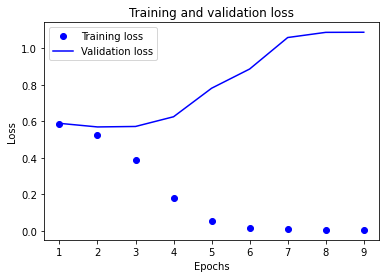

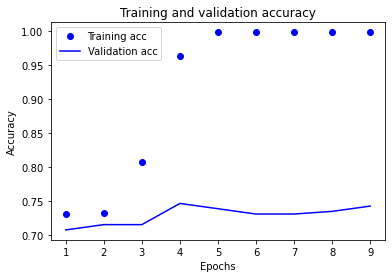

In [35]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=9,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Findings

It was interesting to see how the bios were slightly better at predicting the tweet category than the tweet text itself.


Tweets: ~71.6% Accuracy

Bios: ~74.3% Accuracy

## Potential Future Exploration

A potential future adaptation of this model would be to process the About pages of Crisis Preganacy Centers. Crisis Pregnancy Centers are organizations that provide services and to support pregnant people, often with the aim of persuading them to choose alternatives to abortion. These centers often use deceptive tactics, misinformation, and coercion to dissuade people from seeking abortions, often causing significant harm to the pregnant person's wellbeing. Some CPCs have also been criticized for providing medical advice without proper training or licensing.

Being able to have a tool to identify these places just based on the text on their website would be a huge step towards helping people avoid these centers if they are looking for accurate and stigma-free medical advice.

Currently, the biggest barrier to creating a classifier for this is just that there is not currently a database for this information, and it could be time-consuming to collect all of this data.
